If running in a new environment, such as Google Colab, run this first.

In [1]:
# !git clone https://github.com/zach401/acnportal.git
# !pip install acnportal/.

# ACN-Sim Tutorial: Lesson 2
## Implementing a Custom Algorithm
### by Zachary Lee
#### Last updated: 03/19/2019

In this lesson we will learn how to develop a custom algorithm and run it using ACN-Sim. For this example we will be writing an Earliest Deadline First Algorithm. This algorithm is already available as part of the SortingAlgorithm in the algorithms package, so we will compare the results of our implementation with the included one.

## Custom Algorithm

All custom algorithms should inherit from the abstract class BaseAlgorithm. It is the responsibility of all derived classes to implement the schedule method. This method takes as an input a list of EVs which are currently connected to the system but have not yet finished charging. Its output is a dictionary which maps a station_id to a list of charging rates. Each charging rate is valid for one period measured relative to the current period.

For Example: 
 * schedule[‘abc’][0] is the charging rate for station ‘abc’ during the current period 
 * schedule[‘abc’][1] is the charging rate for the next period 
 * and so on. 
 
If an algorithm only produces charging rates for the current time period, the length of each list should be 1. If this is the case, make sure to also set the maximum resolve period to be 1 period so that the algorithm will be called each period. An alternative is to repeat the charging rate a number of times equal to the max recompute period.

As mentioned previously our new algorithm should inherit from BaseAlgorithm or a subclass of it.

#### def __init__(self, increment=1):

We can override the __init__() method if we need to pass additional configuration information to the algorithm. In this case we pass in the increment which will be used when searching for a feasible rate.

#### schedule(self, active_evs)

We next need to override the schedule() method. The signature of this method should remain the same, as it is called internally in Simulator. If an algorithm needs additional parameters consider passing them through the constructor.

In [2]:
from acnportal.algorithms import BaseAlgorithm
import math
class EarliestDeadlineFirstAlgo(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda x: x.estimated_departure)

        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

Note the structure of the schedule dict which is returned should be something like:

```
{
    'CA-301': [32, 32, 32, 16, 16, ..., 8],
    'CA-302': [8, 13, 13, 15, 6, ..., 0],
    ...,
    'CA-408': [24, 24, 24, 24, 0, ..., 0]
}
```
For the special case when an algorithm only calculates a target rate for the next time interval instead of an entire schedule of rates, the structure should be:

```
{
    'CA-301': [32],
    'CA-302': [8],
    ...,
    'CA-408': [24]
}
```

Note that these are single element lists and NOT floats or integers.

In [3]:
from acnportal.algorithms import BaseAlgorithm, UpperBoundEstimatorBase, infrastructure_constraints_feasible,format_array_schedule
from acnportal.algorithms import (
     enforce_pilot_limit,
     apply_upper_bound_estimate,
     apply_minimum_charging_rate,
     remove_finished_sessions,
 )
import numpy as np

# from upper_bound_estimator import UpperBoundEstimatorBase
# from base_algorithm import BaseAlgorithm
# from utils import infrastructure_constraints_feasible
# from postprocessing import format_array_schedule
# from preprocessing import (
#     enforce_pilot_limit,
#     apply_upper_bound_estimate,
#     apply_minimum_charging_rate,
#     remove_finished_sessions,
# )
from warnings import warn

from acnportal.acnsim.interface import SessionInfo, InfrastructureInfo, Interface

class LeastLaxityFirstGrouped(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    laxities from smallest to highest.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by laxities. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1, tolerance=0.1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1
        self.amount_to_maximum_rate = 10
        self.tolerance = tolerance
    def laxity(self,ev: SessionInfo) -> float:
        """ Calculate laxity of the EV.

        Args:
            ev (EV): An EV object.

        Returns:
            float: The laxity of the EV.
        """
        lax = (ev.estimated_departure - self.interface.current_time) - (
            self.interface.remaining_amp_periods(ev) / self.interface.max_pilot_signal(ev.station_id)
        )
        return lax
    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}

        # # sorted_evs = sorted(active_evs, key=(ev.estimated_departure - iface.current_time) - (
        #     iface.remaining_amp_periods(ev) / iface.max_pilot_signal(ev.station_id)
        # ))
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda ev: self.laxity(ev))
        for ev in sorted_evs:
            print('laxity', self.laxity(ev))
        ev_groups = [[] for i in range(len(sorted_evs))]
        index = -1
        for ev1_ind in range(len(sorted_evs)):
            index += 1
            for ev2_ind in range(ev1_ind + 1, len(sorted_evs)):
                first_ev, second_ev = sorted_evs[ev1_ind], sorted_evs[ev2_ind]
                if abs(self.laxity(first_ev) - self.laxity(second_ev)) < self.tolerance:
                    ev_groups[index].extend([first_ev, second_ev])
        for group in ev_groups:
            for ev in group:
                schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]
            
            while not self.interface.is_feasible(schedule, 0):
                for ev in group:
                    # Since the maximum rate was not feasible, we should try a lower rate.
                    schedule[ev.station_id][0] -= self._increment

                    # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                    if schedule[ev.station_id][0] < 0:
                        schedule[ev.station_id] = [0]
                if group.count(0) == len(group):
                    break
        return schedule
                    
                
                
            
            
        
        # # We now iterate over the sorted list of EVs.
        # for ev in sorted_evs:
        #     # First try to charge the EV at its maximum rate. Remember that each schedule value
        #     #   must be a list, even if it only has one element.
        #     schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

        #     # If this is not feasible, we will reduce the rate.
        #     #   interface.is_feasible() is one way to interact with the constraint set
        #     #   of the network. We will explore another more direct method in lesson 3.
        #     while not self.interface.is_feasible(schedule, 0):

        #         # Since the maximum rate was not feasible, we should try a lower rate.
        #         schedule[ev.station_id][0] -= self._increment

        #         # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
        #         if schedule[ev.station_id][0] < 0:
        #             schedule[ev.station_id] = [0]
        #             break
        # return schedule
        



In [4]:
from acnportal.contrib.acnsim import StochasticNetwork
def level_1_network(transformer_cap=200, evse_per_phase=34):
    """ Configurable charging network for level-1 EVSEs connected line to ground
        at 120 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    voltage = 120

    # Define the sets of EVSEs in the Caltech ACN.
    A_ids = ['A-{0}'.format(i) for i in range(evse_per_phase)]
    B_ids = ['B-{0}'.format(i) for i in range(evse_per_phase)]
    C_ids = ['C-{0}'.format(i) for i in range(evse_per_phase)]

    # Add Caltech EVSEs
    for evse_id in A_ids:
        network.register_evse(acnsim.FiniteRatesEVSE(evse_id, [0, 16]), voltage, 0)
    for evse_id in B_ids:
        network.register_evse(acnsim.FiniteRatesEVSE(evse_id, [0, 16]), voltage, 120)
    for evse_id in C_ids:
        network.register_evse(acnsim.FiniteRatesEVSE(evse_id, [0, 16]), voltage, -120)

    # Add Caltech Constraint Set
    I3a = acnsim.Current(A_ids)
    I3b = acnsim.Current(B_ids)
    I3c = acnsim.Current(C_ids)

    # Define intermediate currents
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 277
    secondary_side_constr = transformer_cap * 1000 / 3 / 120
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network


def level_2_network(transformer_cap=200, evse_per_phase=34):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 208 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    voltage = 208
    evse_type = 'AeroVironment'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(evse_per_phase)]
    BC_ids = ['BC-{0}'.format(i) for i in range(evse_per_phase)]
    CA_ids = ['CA-{0}'.format(i) for i in range(evse_per_phase)]

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 277
    secondary_side_constr = transformer_cap * 1000 / 3 / 120
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

## Running the Algorithm

Now that we have implemented our algorithm, we can try it out using the same experiment setup as in lesson 1. The only difference will be which scheduling algorithm we use. For fun, lets compare our algorithm against to included implementation of the earliest deadline first algorithm.

In [5]:
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from copy import deepcopy

from acnportal import algorithms
from acnportal import acnsim

from acnportal.signals.tariffs.tou_tariff import TimeOfUseTariff
# -- Experiment Parameters ---------------------------------------------------------------------------------------------
timezone = pytz.timezone('America/Los_Angeles')
start = timezone.localize(datetime(2018, 9, 5))
end = timezone.localize(datetime(2018, 9, 10))
period = 5  # minute
voltage = 220  # volts
default_battery_power = 32 * voltage / 1000 # kW
site = 'caltech'
signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}


# -- Network -----------------------------------------------------------------------------------------------------------
# cn = acnsim.sites.caltech_acn(basic_evse=True, voltage=voltage)
cn = acnsim.sites.caltech_acn(basic_evse=False, voltage=voltage)
# -- Events ------------------------------------------------------------------------------------------------------------
API_KEY = 'DEMO_TOKEN'
events = acnsim.acndata_events.generate_events(API_KEY, site, start, end, period, voltage, default_battery_power)


# -- Scheduling Algorithm ----------------------------------------------------------------------------------------------
sch = EarliestDeadlineFirstAlgo(increment=1)
sch2 = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
sch3 = LeastLaxityFirstGrouped(increment=1,tolerance=30)

In [6]:
cn_lvl2_200kw_30 = level_1_network(transformer_cap=200, evse_per_phase=34)

In [7]:
# -- Simulator ---------------------------------------------------------------------------------------------------------
uncontrolled = algorithms.UncontrolledCharging()

sim = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), uncontrolled, deepcopy(events), start,signals=signals, period=period, verbose=False)
sim.run()

In [8]:
# For comparison we will also run the builtin earliest deadline first algorithm
sim2 = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), sch2, deepcopy(events), start, signals=signals, period=period, verbose=False)
sim2.run()

In [9]:
sim3 = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), sch3, deepcopy(events), start, signals=signals, period=period, verbose=False)
sim3.run()

laxity 552.3045086805555
laxity 551.3045086805555
laxity 550.3045086805555
laxity 549.3045086805555
laxity 548.3045086805555
laxity 547.3045086805555
laxity 546.3045086805555
laxity 545.3045086805555
laxity 544.3045086805555
laxity 543.3045086805555
laxity 542.3045086805555
laxity 541.3045086805555
laxity 540.3045086805555
laxity 539.3045086805555
laxity 538.3045086805555
laxity 537.3045086805555
laxity 536.3045086805555
laxity 535.3045086805555
laxity 534.3045086805555
laxity 533.3045086805555
laxity 532.3045086805555
laxity 531.3045086805555
laxity 530.3045086805555
laxity 529.3045086805555
laxity 528.3045086805555
laxity 527.3045086805555
laxity 526.3045086805555
laxity 525.3045086805555
laxity 524.3045086805555
laxity 523.3045086805555
laxity 522.3045086805555
laxity 521.3045086805555
laxity 520.3045086805555
laxity 519.3045086805555
laxity 518.3045086805555
laxity 517.3045086805555
laxity 516.3045086805555
laxity 515.3045086805555
laxity 514.3045086805555
laxity 513.3045086805555


## Results

We can now compare the two algorithms side by side by looking that the plots of aggregated current. We see from these plots that our implementation matches th included one quite well. If we look closely however, we might see a small difference. This is because the included algorithm uses a more efficient bisection based method instead of our simpler linear search to find a feasible rate.

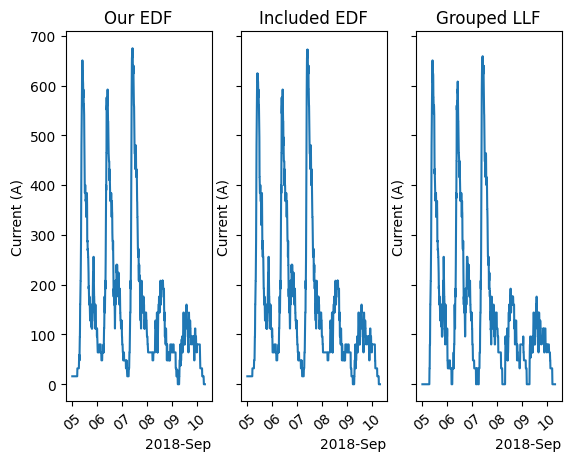

In [10]:
# Get list of datetimes over which the simulations were run.
sim_dates = mdates.date2num(acnsim.datetimes_array(sim))
sim2_dates = mdates.date2num(acnsim.datetimes_array(sim2))
sim3_dates = mdates.date2num(acnsim.datetimes_array(sim3))


# Set locator and formatter for datetimes on x-axis.
locator = mdates.AutoDateLocator(maxticks=6)
formatter = mdates.ConciseDateFormatter(locator)

fig, axs = plt.subplots(1, 3, sharey=True, sharex=True)
axs[0].plot(sim_dates, acnsim.aggregate_current(sim), label='Our EDF')
axs[1].plot(sim2_dates, acnsim.aggregate_current(sim2), label='Included EDF')
axs[2].plot(sim3_dates, acnsim.aggregate_current(sim3), label='Grouped LLF')
axs[0].set_title('Our EDF')
axs[1].set_title('Included EDF')
axs[2].set_title('Grouped LLF')
for ax in axs:
    ax.set_ylabel('Current (A)')
    for label in ax.get_xticklabels():
        label.set_rotation(40)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

plt.show()





In [11]:
import pandas as pd
total_energy_prop = acnsim.proportion_of_energy_delivered(sim)
total_energy_prop2 = acnsim.proportion_of_energy_delivered(sim2)
total_energy_prop3 = acnsim.proportion_of_energy_delivered(sim3)

all_simulations = [sim, sim2, sim3]
all_simulations_names = ['Our early deadline first', 'Their LLF', 'My grouped LLF']
print(f'Proportion of energy delivered for sim: {total_energy_prop}')
print(f'Proportion of energy delivered for sim: {total_energy_prop2}')
print(f'Proportion of energy delivered for sim: {total_energy_prop3}')

# Data pro tabulku
data = {
    'Simulation name': [],
    'Proportion of energy delivered': [],
    'energy_cost':[],
    'Energy delivered':[],
}

for i, simulation in enumerate(all_simulations):
    data['Simulation name'].append(all_simulations_names[i])
    data['Proportion of energy delivered'].append( acnsim.proportion_of_energy_delivered(simulation))
    data['Energy delivered'].append(sum(ev.energy_delivered for ev in all_simulations[i].ev_history.values()))
    data['energy_cost'].append(acnsim.energy_cost(all_simulations[i]))

# Vytvoření DataFrame
df = pd.DataFrame(data)

# Vytisknutí tabulky
print(df)



Proportion of energy delivered for sim: 0.714045290316249
Proportion of energy delivered for sim: 0.7098778911381477
Proportion of energy delivered for sim: 0.6716410115471405
            Simulation name  Proportion of energy delivered  energy_cost  \
0  Our early deadline first                        0.714045   302.585977   
1                 Their LLF                        0.709878   300.238002   
2            My grouped LLF                        0.671641   289.694581   

   Energy delivered  
0       2399.926748  
1       2385.920000  
2       2257.404748  
